In [1]:
import os
import pickle
from PIL import Image 
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [3]:
input_dir = 'D:/Téléchargements/archive/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/data'
categories = ['nothing','smoke','fire']

In [5]:
data = []
labels = []

# Taille cible pour le redimensionnement des images
target_size = (100, 100)

# Chargement et préparation des images
for category_idx, category in enumerate(categories):
    category_dir = os.path.join(input_dir, category)
    if os.path.isdir(category_dir):
        for file in os.listdir(category_dir):
            img_path = os.path.join(category_dir, file)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Convertir en RGB
                    img = np.array(img)  # Convertir en tableau NumPy
                    img = resize(img, target_size, anti_aliasing=True)  # Redimensionner l'image
                    data.append(img.flatten())  # Aplatir l'image et ajouter au dataset
                    labels.append(category_idx)  # Ajouter l'étiquette correspondante
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

# Conversion des listes en tableaux NumPy
data = np.array(data)
labels = np.array(labels)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)


In [7]:
# Normalisation des données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [12]:
parameters = {'C': [1, 10, 100], 'gamma': ['scale', 'auto',0.01, 0.001], 'kernel': ['rbf']}
classifier = SVC()
grid_search = GridSearchCV(classifier, parameters, cv=5,n_jobs=3)
grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=3,
             param_grid={'C': [1, 10, 100],
                         'gamma': ['scale', 'auto', 0.01, 0.001],
                         'kernel': ['rbf']})

In [13]:
# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score de validation croisée:", grid_search.best_score_)

Meilleurs paramètres: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Meilleur score de validation croisée: 0.9445367787392641


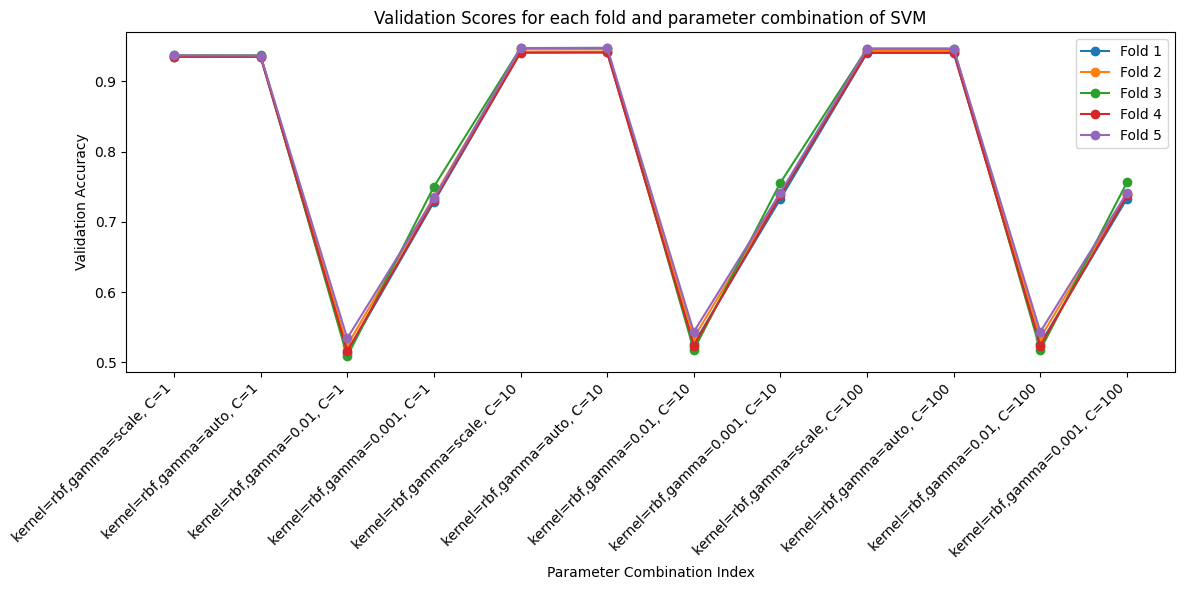

In [14]:
import matplotlib.pyplot as plt

# Supposons que grid_search a déjà été exécuté avec les paramètres SVC
scores_fold = grid_search.cv_results_['split0_test_score']
params_svm = grid_search.cv_results_['params']

# Préparer les listes pour les axes x et y
x_values_svm = [i for i in range(len(params_svm))]
labels_svm = [f"kernel={p['kernel']},gamma={p['gamma']}, C={p['C']}" for p in params_svm]

# Tracer les scores de validation pour chaque pli
plt.figure(figsize=(12, 6))

# Boucle pour tracer chaque ensemble de scores par pli
for i in range(5):
    fold_scores = grid_search.cv_results_[f'split{i}_test_score']
    plt.plot(x_values_svm, fold_scores, marker='o', linestyle='-', label=f'Fold {i+1}')

plt.title('Validation Scores for each fold and parameter combination of SVM')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.xticks(x_values_svm, labels_svm, rotation=45, ha="right")
plt.legend()
plt.tight_layout()  # Ajuster automatiquement pour éviter le chevauchement
plt.show()


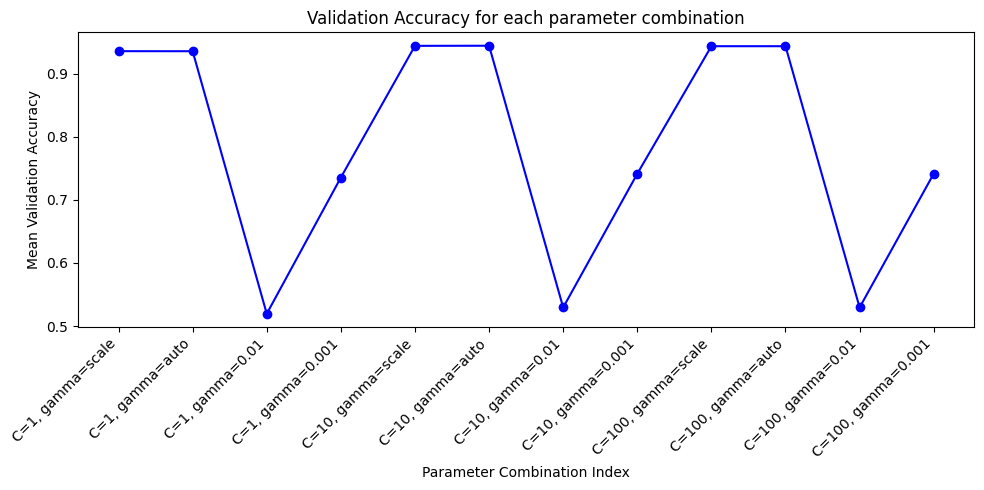

In [15]:
import matplotlib.pyplot as plt

# Extraire les scores de validation moyens et les paramètres correspondants
mean_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']

# Préparer les listes pour les axes x et y
x_values = [i for i in range(len(params))]
labels = [f"C={p['C']}, gamma={p['gamma']}" for p in params]

# Tracer les scores de validation en fonction des paramètres
plt.figure(figsize=(10, 5))
plt.plot(x_values, mean_scores, marker='o', linestyle='-', color='b')
plt.title('Validation Accuracy for each parameter combination')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean Validation Accuracy')
plt.xticks(x_values, labels, rotation=45, ha="right")
plt.tight_layout()  # Ajuster automatiquement pour éviter le chevauchement
plt.show()

In [16]:
# Utilisation des meilleurs paramètres pour créer le modèle final
best_classifier = grid_search.best_estimator_
y_prediction = best_classifier.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, y_prediction)

In [17]:
# Affichage des résultats
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.9532493368700266


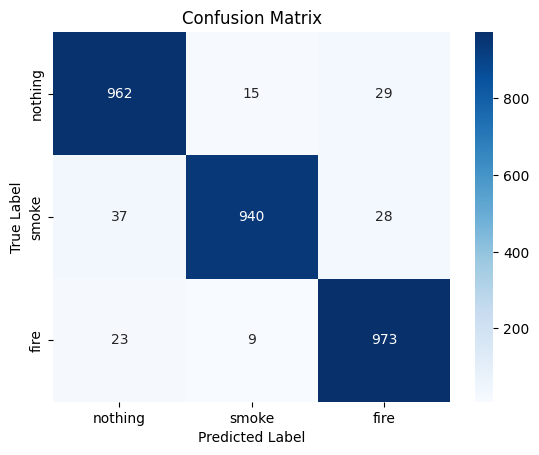

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_prediction)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Affichage du rapport de classification
from sklearn.metrics import classification_report  # Import the classification_report function
classification_rep = classification_report(y_test, y_prediction)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1006
           1       0.98      0.94      0.95      1005
           2       0.94      0.97      0.96      1005

    accuracy                           0.95      3016
   macro avg       0.95      0.95      0.95      3016
weighted avg       0.95      0.95      0.95      3016



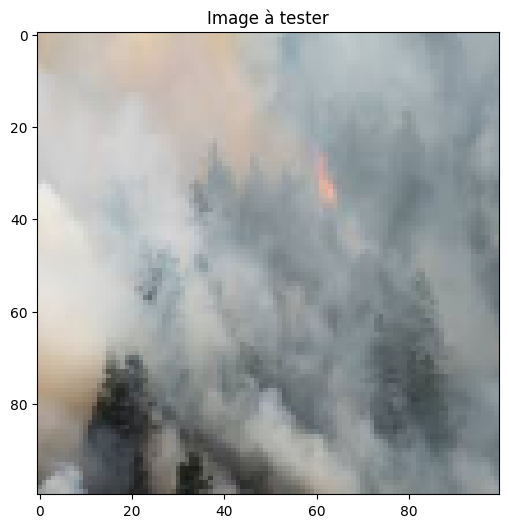

Catégorie prédite: smoke


In [20]:
new_image_path = 'D:/Téléchargements/images.jpg'

try:
    with Image.open(new_image_path) as img:
        img = img.convert('RGB')  # Convertir en RGB
        img = np.array(img)  # Convertir en tableau NumPy
        img_resized = resize(img, target_size, anti_aliasing=True)  # Redimensionner selon le modèle
    # Afficher l'image
        plt.figure(figsize=(6, 6))
        plt.imshow(img_resized)
        plt.title('Image à tester')
        plt.show()
        # Convertir l'image pour correspondre à l'entrée du modèle
        img_processed = img_resized.flatten().reshape(1, -1)

        # Normaliser l'image avec le même scaler utilisé pour les données d'entraînement
        img_normalized = scaler.transform(img_processed)

        # Utiliser le modèle pour faire une prédiction
        predicted_category_index = best_classifier.predict(img_normalized)[0]
        
        # Afficher la catégorie prédite
        print(f'Catégorie prédite: {categories[predicted_category_index]}')
        
except Exception as e:
    print(f"Erreur lors de la lecture de l'image {new_image_path}: {e}")

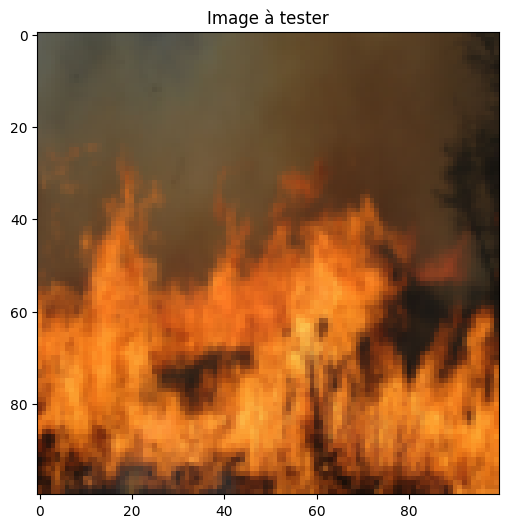

Catégorie prédite: fire


In [21]:
new_image_path = 'D:/Téléchargements/000.jpeg'

try:
    with Image.open(new_image_path) as img:
        img = img.convert('RGB')  # Convertir en RGB
        img = np.array(img)  # Convertir en tableau NumPy
        img_resized = resize(img, target_size, anti_aliasing=True)  # Redimensionner
        
        # Afficher l'image
        plt.figure(figsize=(6, 6))
        plt.imshow(img_resized)
        plt.title('Image à tester')
        plt.show()
        
        # Aplatir l'image si votre modèle attend des données aplaties
        img_processed = img_resized.flatten().reshape(1, -1)
        img_normalized = scaler.transform(img_processed)

        # Utilisation du modèle pour faire une prédiction
        predicted_category_index = best_classifier.predict(img_normalized)[0]

        
        # Afficher la catégorie prédite
        print(f'Catégorie prédite: {categories[predicted_category_index]}')
        
except Exception as e:
    print(f"Erreur lors de la lecture de l'image {new_image_path}: {e}")

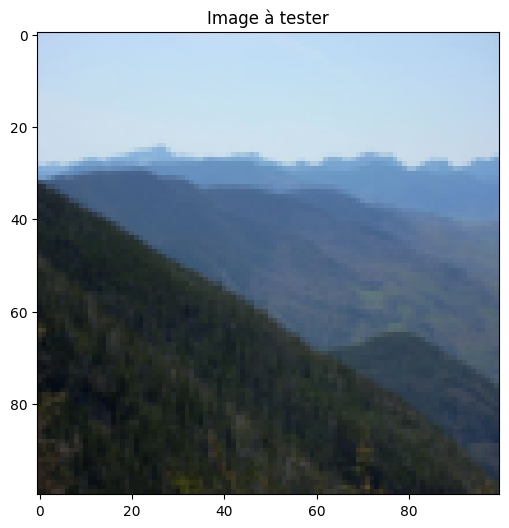

Catégorie prédite: nothing


In [22]:
new_image_path = 'D:/Téléchargements/ff.jpg'

try:
    with Image.open(new_image_path) as img:
        img = img.convert('RGB')  # Convertir en RGB
        img = np.array(img)  # Convertir en tableau NumPy
        img_resized = resize(img, target_size, anti_aliasing=True)  # Redimensionner
        
        # Afficher l'image
        plt.figure(figsize=(6, 6))
        plt.imshow(img_resized)
        plt.title('Image à tester')
        plt.show()
        
        # Aplatir l'image si votre modèle attend des données aplaties
        img_processed = img_resized.flatten().reshape(1, -1)
        img_normalized = scaler.transform(img_processed)

        # Utilisation du modèle pour faire une prédiction
        predicted_category_index = best_classifier.predict(img_normalized)[0]

        
        # Afficher la catégorie prédite
        print(f'Catégorie prédite: {categories[predicted_category_index]}')
        
except Exception as e:
    print(f"Erreur lors de la lecture de l'image {new_image_path}: {e}")

In [23]:
pickle.dump(best_classifier, open('C:/Users/chatt/Desktop/svmrbfCV.p', 'wb'))